# Random Forest Classifier for Dwarf and Giant stars in the CFIS crossmatched catalog
## Author: Nic Annau, University of Victoria
## Date: Summer, 2018
## Requirements: catalogue.py


In [1]:
from catalogue import *

/opt/conda/lib/python2.7/site-packages/astropy/table/np_utils.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _np_utils
/opt/conda/lib/python2.7/site-packages/astropy/io/ascii/fastbasic.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import cparser
Using TensorFlow backend.
/opt/conda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load training data, see catalogue.py for load data function.

In [2]:
inputs, outputs, error, df_original = load_data()
print "Total number of stars:", inputs.shape[0]

/opt/conda/lib/python2.7/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


Total number of stars: 142750


In [3]:
# Select only the lowest error in logg
logg_error_thres = 0.16

# Apply above loegg error threshold. i.e. select only stars with good logg data
logg_cut = (error['dlogg'] <= logg_error_thres)

# Remove unecessary columns after applying cuts
inputs = inputs[logg_cut].reset_index(drop=True)
outputs = outputs[logg_cut].reset_index(drop=True)
error = error[logg_cut].reset_index(drop=True)

### Assign 'dwarf' or 'giant' for the classifier

In [4]:
# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant
outputs['logg_binary'] = np.where(outputs['logg'] > 3.5, 'dwarf', 'giant')

print "Total number of stars after cuts:", inputs.shape[0]

Total number of stars after cuts: 129540


In [5]:
# Shuffle the dataframes randomly
seed = random.randint(1,101) # Get random integer to shuffle the inputs and outputs randomly, but the same way
inputs = inputs.sample(frac=1, random_state = seed).reset_index(drop=True)
outputs = outputs.sample(frac=1, random_state = seed).reset_index(drop=True)

In [6]:
# Normalize the data using custom normalize function
# default is using mean and stdev. Errors use min_max method
inputf = normalize(inputs)
outputf = normalize(outputs)

In [7]:
# Create the features and add to new dataframe
inputs_col = pd.DataFrame()

inputs_col['u-g']=inputf['u']-inputf['g']
inputs_col['g-r']=inputf['g']-inputf['r']
inputs_col['r-i']=inputf['r']-inputf['i']
inputs_col['i-z']=inputf['i']-inputf['z']
inputs_col['z-y']=inputf['z']-inputf['y']
inputs_col['u-G']=inputf['u']-inputf['G']
inputs_col['u-RP']=inputf['u']-inputf['RP']
inputs_col['u-BP']=inputf['u']-inputf['BP']

### Split the inputs and outputs into test and train datasets

In [8]:
# Split spectroscopic sample with colours
inputf_train, inputf_test, outputf_train, outputf_test = train_test_split(inputs_col, outputf, test_size=0.2, random_state=42)
# Split spectroscopic sample the same way but while preserving the above split
input_full_train, input_full_test, output_full_train, output_full_test = train_test_split(inputf, outputf, test_size=0.2, random_state=42)

### Encode the output features

In [9]:
# Encode class values as integers

# Encode train data
encoder = LabelEncoder()
encoder.fit(outputf_train['logg_binary'])
encoded_Y_train = encoder.transform(outputf_train['logg_binary'])

# Encode test data
encoder = LabelEncoder()
encoder.fit(outputf_test['logg_binary'])
encoded_Y_test = encoder.transform(outputf_test['logg_binary'])

# Results of fine tuning for RF
param_grid = {"n_estimators": 593,
              "max_depth": 15,
              "min_samples_split": 2,
              "min_samples_leaf": 1,
              "max_leaf_nodes": 1850,
              "min_weight_fraction_leaf": 0.1}

### Train the RF classifier

In [10]:
crf = sklearn.ensemble.RandomForestClassifier(n_estimators=593, max_depth=15, min_samples_leaf=2, max_leaf_nodes=1850, verbose=1, n_jobs=-1)
crf.fit(inputf_train, encoded_Y_train)

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 593 out of 593 | elapsed:    6.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=1850,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=593, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

### Calibrate the probabilities predicted by the random forest.

In [11]:
rf = CalibratedClassifierCV(base_estimator=crf, method='sigmoid', cv='prefit')
rf.fit(inputf_train, encoded_Y_train)

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.7s finished


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=1850,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=593, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False),
            cv='prefit', method='sigmoid')

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


F1 Score: 0.9579375848032563


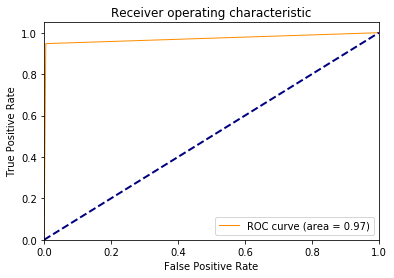

In [12]:
pred = rf.predict(inputf_test)

print "F1 Score:", sklearn.metrics.f1_score(encoded_Y_test, pred, average='binary')

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(encoded_Y_test, pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Load the Globular Cluster data and do the following:
1. Apply cuts to proper motion and colors to show relevent CMD area
2. Remove any non-numbers
3. Convert the raw globular cluster columns to features (convert to color)
4. Normalize while convering to color
5. Predict the probabilities of being a dwarf/giant
6. Predict which class the prediction belongs to

In [13]:
inputs_NGC6341 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6341.fits')
inputs_NGC6205 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6205.fits')
inputs_NGC5466 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5466.fits')
inputs_NGC5272 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5272.fits')

##############################
## NGC 6341 ##
##############################
criteria = criteria_function(inputs_NGC6341, 0.2, 2.5, 0)
inputs_NGC6341 = inputs_NGC6341[criteria]
inputs_NGC6341 = (inputs_NGC6341.dropna())
inputs_NGC6341_b = change_to_colour(inputs_NGC6341, inputs_col)
inputs_NGC6341['dwarf'] =  rf.predict_proba(inputs_NGC6341_b.values)[:,0]
inputs_NGC6341['giant'] =  rf.predict_proba(inputs_NGC6341_b.values)[:,1]
inputs_NGC6341['class_binary'] =  rf.predict(inputs_NGC6341_b.values)


##############################
## NGC 6205 ##
##############################
criteria = criteria_function(inputs_NGC6205, 0.13, 2.5, 0)
inputs_NGC6205 = inputs_NGC6205[criteria]
inputs_NGC6205 = (inputs_NGC6205.dropna())
inputs_NGC6205_b = change_to_colour(inputs_NGC6205, inputs_col)
inputs_NGC6205['dwarf'] =  rf.predict_proba(inputs_NGC6205_b.values)[:,0]
inputs_NGC6205['giant'] =  rf.predict_proba(inputs_NGC6205_b.values)[:,1]
inputs_NGC6205['class_binary'] =  rf.predict(inputs_NGC6205_b.values)

##############################
## NGC 5466 ##
##############################
criteria = criteria_function(inputs_NGC5466, 0.26, 2.5, 0)
inputs_NGC5466 = inputs_NGC5466[criteria]
inputs_NGC5466 = (inputs_NGC5466.dropna())
inputs_NGC5466_b = change_to_colour(inputs_NGC5466, inputs_col)
inputs_NGC5466['dwarf'] =  rf.predict_proba(inputs_NGC5466_b.values)[:,0]
inputs_NGC5466['giant'] =  rf.predict_proba(inputs_NGC5466_b.values)[:,1]
inputs_NGC5466['class_binary'] =  rf.predict(inputs_NGC5466_b.values)

##############################
## NGC 5272 ##
##############################
criteria = criteria_function(inputs_NGC5272, 0.14, 2.5, 0)
inputs_NGC5272 = inputs_NGC5272[criteria]
inputs_NGC5272 = (inputs_NGC5272.dropna())
inputs_NGC5272_b = change_to_colour(inputs_NGC5272, inputs_col)
inputs_NGC5272['dwarf'] =  rf.predict_proba(inputs_NGC5272_b.values)[:,0]
inputs_NGC5272['giant'] =  rf.predict_proba(inputs_NGC5272_b.values)[:,1]
inputs_NGC5272['class_binary'] =  rf.predict(inputs_NGC5272_b.values)

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 

### Plot the CMDs with color-coded predictions of dwarf or giant.
#### Show the luminosity function for the probability prediction, as well as the binary prediction of the model
---
### Warning! Is computationally heavy!

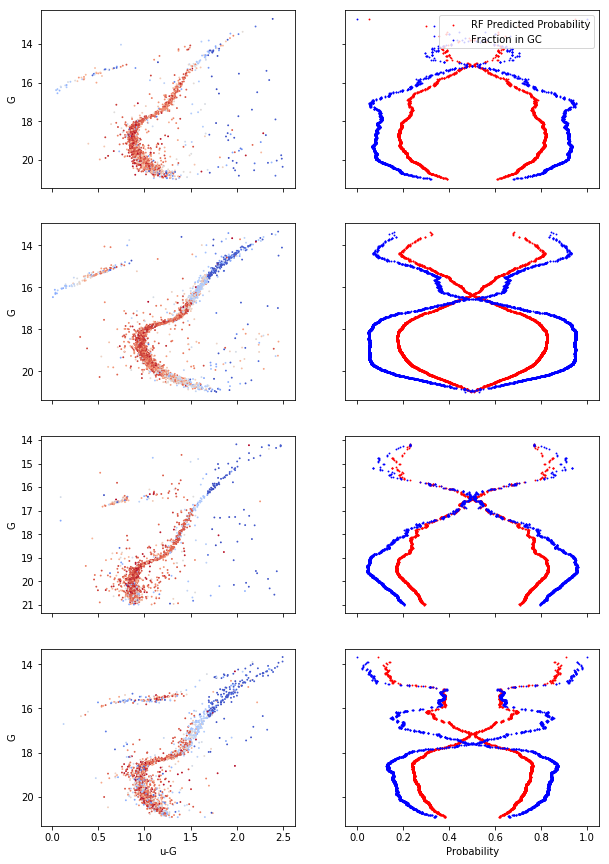

In [14]:
# Warning, takes a while to run..........

fig, ax = plt.subplots(4, 2, figsize=(10, 15),  sharex='col', sharey='row')

NGC6341_probs = prob_frac(0.5, inputs_NGC6341)
ax[0, 0].scatter((inputs_NGC6341['u']-inputs_NGC6341['G']).values, inputs_NGC6341['G'].values, s=0.75, c=inputs_NGC6341['dwarf'], cmap=plt.cm.coolwarm)
ax[0, 1].scatter(NGC6341_probs[0], NGC6341_probs[2], s=0.75, color='red', label='RF Predicted Probability')
ax[0, 1].scatter(NGC6341_probs[1], NGC6341_probs[2], s=0.75, color='red')
ax[0, 1].scatter(lum_frac(.5, inputs_NGC6341)[2], lum_frac(.5, inputs_NGC6341)[0], s=0.75, color='blue')
ax[0, 1].scatter(lum_frac(.5, inputs_NGC6341)[1], lum_frac(.5, inputs_NGC6341)[0], s=0.75, color='blue', label='Fraction in GC')
ax[0, 1].legend()
ax[0, 0].set_ylabel('G')
ax[0, 0].invert_yaxis()

NGC6205_probs = prob_frac(0.5, inputs_NGC6205)
ax[1, 0].scatter((inputs_NGC6205['u']-inputs_NGC6205['G']).values, inputs_NGC6205['G'].values, s=0.75, c=inputs_NGC6205['dwarf'], cmap=plt.cm.coolwarm)
ax[1, 1].scatter(NGC6205_probs[0], NGC6205_probs[2], s=0.75, color='red')
ax[1, 1].scatter(NGC6205_probs[1], NGC6205_probs[2], s=0.75, color='red')
ax[1, 1].scatter(lum_frac(.5, inputs_NGC6205)[2], lum_frac(.5, inputs_NGC6205)[0], s=0.75, color='blue')
ax[1, 1].scatter(lum_frac(.5, inputs_NGC6205)[1], lum_frac(.5, inputs_NGC6205)[0], s=0.75, color='blue')
ax[1, 0].set_ylabel('G')
ax[1, 0].invert_yaxis()

NGC5466_probs = prob_frac(0.5, inputs_NGC5466)
ax[2, 0].scatter((inputs_NGC5466['u']-inputs_NGC5466['G']).values, inputs_NGC5466['G'].values, s=0.75, c=inputs_NGC5466['dwarf'], cmap=plt.cm.coolwarm)
ax[2, 1].scatter(NGC5466_probs[0], NGC5466_probs[2], s=0.75, color='red')
ax[2, 1].scatter(NGC5466_probs[1], NGC5466_probs[2], s=0.75, color='red')
ax[2, 1].scatter(lum_frac(.5, inputs_NGC5466)[2], lum_frac(.5, inputs_NGC5466)[0], s=0.75, color='blue')
ax[2, 1].scatter(lum_frac(.5, inputs_NGC5466)[1], lum_frac(.5, inputs_NGC5466)[0], s=0.75, color='blue')
ax[2, 0].set_ylabel('G')
ax[2, 0].invert_yaxis()

NGC5272_probs = prob_frac(0.5, inputs_NGC5272)
ax[3, 0].scatter((inputs_NGC5272['u']-inputs_NGC5272['G']).values, inputs_NGC5272['G'].values, s=0.75, c=inputs_NGC5272['dwarf'], cmap=plt.cm.coolwarm)
ax[3, 1].scatter(NGC5272_probs[0], NGC5272_probs[2], s=0.75, color='red')
ax[3, 1].scatter(NGC5272_probs[1], NGC5272_probs[2], s=0.75, color='red')
ax[3, 1].scatter(lum_frac(.5, inputs_NGC5272)[2], lum_frac(.5, inputs_NGC5272)[0], s=0.75, color='blue')
ax[3, 1].scatter(lum_frac(.5, inputs_NGC5272)[1], lum_frac(.5, inputs_NGC5272)[0], s=0.75, color='blue')
ax[3, 0].invert_yaxis()
ax[3, 0].set_ylabel('G')
ax[3, 0].set_xlabel('u-G')
ax[3, 1].set_xlabel('Probability')
plt.savefig('./plots/rf_col/random_forrest')

### Synthesize the lime results by reporting how important the features were for a fraction of the instances in the training set.

In [15]:
# KEEP FRAC SMALL UNLESS YOU WANT TO CALCULATE THIS FOR A LONG TIME!
# 0.001 is overly small, but is meant for testing and not for evaluating.
frac = 0.001
lime_synthesizer(rf, inputf_test, inputf_train, 1, 0,frac=0.001)

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished
catalogue.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inputf_test['class_pred'] = rf.predict(inputf_test)


0
0 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


1 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


2 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


3 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


4 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


5 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


6 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


7 of 22


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


8 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


9 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


10 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


11 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


12 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


13 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


14 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


15 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


16 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


17 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


18 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


19 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


20 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished


21 of 22


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s


    low feature  high       val
6 -0.04     u-g  0.29 -0.080039
5 -0.05    u-RP  0.52 -0.023984
4 -0.04     u-G  0.46 -0.008060
7 -0.01     z-y -0.01 -0.007716
3 -0.03    u-BP  0.38 -0.006680
0 -0.02     g-r -0.02 -0.003436
2 -0.01     r-i  0.07  0.081240
1  0.02     i-z -0.01  0.117266


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.3s finished
/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  after removing the cwd from sys.path.


### Create a luminosity function the same was as for the Globular Clusters. Note G is normalized.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 593 out of 593 | elapsed:    0.6s finished


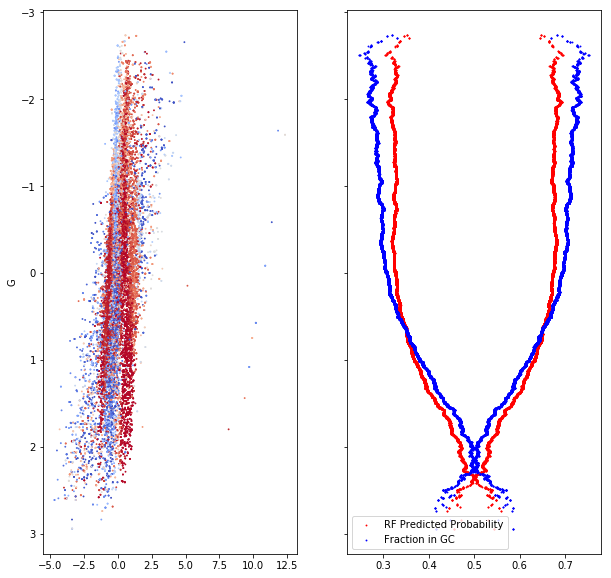

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10),  sharex='col', sharey='row')

input_full_test = (input_full_test.dropna())
input_full_test_b = change_to_colour(input_full_test, inputs_col)
input_full_test['dwarf'] =  rf.predict_proba(input_full_test_b.values)[:,0]
input_full_test['giant'] =  rf.predict_proba(input_full_test_b.values)[:,1]
input_full_test['class_binary'] =  rf.predict(input_full_test_b.values)


mw_probs = prob_frac(0.5, input_full_test)
ax[0].scatter((input_full_test['u']-input_full_test['G']).values, input_full_test['G'].values, s=0.75, c=input_full_test['dwarf'], cmap=plt.cm.coolwarm)
ax[1].scatter(mw_probs[0], mw_probs[2], s=0.75, color='red', label='RF Predicted Probability')
ax[1].scatter(mw_probs[1], mw_probs[2], s=0.75, color='red')
ax[1].scatter(lum_frac(.5, input_full_test)[2], lum_frac(.5, input_full_test)[0], s=0.75, color='blue')
ax[1].scatter(lum_frac(.5, input_full_test)[1], lum_frac(.5, input_full_test)[0], s=0.75, color='blue', label='Fraction in GC')
ax[1].legend()
ax[0].set_ylabel('G')
ax[0].invert_yaxis()
plt.savefig('./plots/mw_lum_frac')